<a href="https://colab.research.google.com/github/eagomez2/mir_basics/blob/main/eagomez_assignment01_exemplary_mir_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIR assignment 01 - Basic flow in an exemplary MIR classification research task 

## Instructions
In this assignment you should understand and reproduce the instrument classification experiment presented in [this jupyter notebook](https://github.com/MTG/MIRCourse/blob/master/notebooks/Lecture1_IntroWithACaseStudy.ipynb), and then adapt the notebook to another instrument classification task, one using the [Mridangam Stroke dataset](https://zenodo.org/record/4068196). The goal is to automatically recognize the 10 different stroke classes or the 6 different tonic classes present in the dataset (you choose), trying to obtain the best possible accuracy. For both tasks you should use the whole dataset.  

The goal of the assignment is to understand and be able to implement all the steps involved in a typical audio-based classification problem. Thus, understanding all the steps involved in designing the experiment and making the best choices for a given task. You should briefly explain within the submitted notebook, all the decisions taken in every step of the experiment.  

You can optionally add a step of feature selection. Feature selection is the removal of redundancies in features, lowering the dimensionality of the feature space. Effective feature selection can improve performance of a classifier and would lower memory and computation requirements.

- Increase the number of classes to 8 (either use more classes from [UIOWA:MIS](http://theremin.music.uiowa.edu/MIS.html) dataset or continue with the Mridangam dataset)

- Add a feature selection step in the process (most critical part)

- Observe and report its contribution, discuss your observations

## About the structure of this notebook

The author has chosen to implement the necessary code for the following tasks:
1. **Tonic classification** of the Mridangam Stroke dataset (6 classes).
2. **Stroke classification** of the Mridangam Stroke dataset (10 classes).
3. **Optional:** Additionally, some techniques for **feature selection**, **class imbalance handling** and **dimensionality reduction** are implemented to evaluate their impact in the aforementioned tasks. A discussion of these techniques is added to each cell.

# Installing Essentia  
Essentia is an open-source library and tools for audio and music analysis, description and synthesis whose documentation can be found [here](https://essentia.upf.edu/).

In [1]:
# Installs Essentia if it's not installed yet
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

# Installs imblearn if it's not installed
if importlib.util.find_spec('imblearn') is None:
    !pip install imblearn

# Imports  
Some other dependencies that are going to be used for the different sections of this notebook.

In [2]:
import os
import sys
import shutil
import zipfile
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import essentia.standard as ess
import seaborn as sns
from tqdm.notebook import tqdm  # Helps to create progress bars during loops
from pathlib import Path
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')  # Ignore some deprecation warnings
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectPercentile, f_classif, RFE, RFECV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

%matplotlib inline
%config InlineBackend.figure_format='retina'  # Fix for retina displays

# Dataset acquisition  
The code in the following sections downloads and uncompresses the Mridangam Stroke dataset, locating it inside the corresponding folder for reading and further processing of the audio files.  

The dataset is comprised of 6 tonic classes and 10 stroke classes named under the following conventions:

> StrokeName_Tonic_InstanceNumber.wav  
> Tonic = {B, C, Csh, D, Dsh, E}  
> StrokeName = {Bheem, Cha, Dheem, Dhin, Num, Ta, Tha, Tham, Thi, Thom}

Additional description about the dataset can be found [here](https://zenodo.org/record/4068196#.YBINk3dKjQg).

## Download helper function  
The following function is created in order to download and uncompress the dataset appropriately.

In [3]:
def download_content(url=None, filename=None, dir='data', chunk_size=1024, unzip=False, delete_original=False, delete_postflight=[]):
  """ Downloads the content to a local folder, unzip it and get rids of
      unnecessary data if necessary.

      Args:
          url (str):                Link of the downloadable dataset.
          filename (str):           Name to be given to the dataset file.
          dir (str):                Folder where the dataset is stored.
          chunk_size (int):         Chunk size for the download streaming.
          unzip (bool):             Unzip after download is completed.
          delete_original (bool):   If True, deletes original file after it is uncompressed.
          delete_postflight (list): List of strings containing folders to be deleted after
              the file is downloaded and unziped.
  """
  r = requests.get(url, stream=True)

  try:
    total_size = int(r.headers['content-length'])
  except:
    total_size = chunk_size    # Content-length may be unknown if the source will only stream the file

  filepath = os.path.join(dir, filename)

  # Make folder if it does not exist
  if not os.path.exists(dir):
    os.mkdir(dir)

  # Download the content
  with open(filepath, 'wb') as file:
    for data in tqdm(iterable=r.iter_content(chunk_size=chunk_size), total=(total_size / chunk_size), unit='MB'):
      file.write(data)
    
  print(f'Content successfully downloaded to {filepath}')

  # Unzip file
  if unzip:
    print(f'Uncompressing {filename}...')
    zip_extractor = zipfile.ZipFile(filepath, 'r')
    zip_extractor.extractall(dir)
    zip_extractor.close()
    print(f'Uncompressed file saved to {dir}...')

  # Delete original folder
  if delete_original:
    print(f'Deleting original file {filepath}...')
    os.remove(filepath)

  # Delete other unnecessary folders
  if delete_postflight:
    for item in delete_postflight:
      item_path = os.path.join(dir, item)
      if os.path.exists(item_path):
        print(f'Deleting unnecessary item {item_path}')
        shutil.rmtree(item_path)

  print('Operation completed!')

## Dataset definitions  
Some dataset related constants are stored to be used in later steps.

**Important:** To speed up the revision of this notebook, if `DOWNLOAD_PRECOMPUTED_DATA` is set to `True`, a copy of the computed features will be downloaded from `PRECOMPUTED_DATA_URL`. If `DOWNLOAD_PRECOMPUTED_DATA` is set to `False`, all features will be computed again.

In [4]:
# If True, data.csv will be obtained and therefore feature extraction
# with Essentia will not be re-computed to save some time executing this notebook.
# The dataset will still be downloaded to visualize the files.
DOWNLOAD_PRECOMPUTED_DATA = True
PRECOMPUTED_DATA_URL = 'https://drive.google.com/u/5/uc?id=1oT62rh-VOxWq5dGr6W2O5vC6t77Kl2R3&export=download'

BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
DATA_ROOT = os.path.join(BASE_DIR, 'data')
DATASET_URL = 'https://zenodo.org/record/4068196/files/mridangam_stroke_1.5.zip'
DATASET_NAME = os.path.splitext(os.path.basename(DATASET_URL))[0]
DATASET_ROOT = os.path.join(DATA_ROOT, DATASET_NAME)
DATASET_FS = 44100

# Some dicts to pattern match file names
TONIC_CLASSES = {
    '-b-':    'b',
    '-c-':    'c',
    '-csh-':  'c#',
    '-d-':    'd',
    '-dsh-':  'd#',
    '-e-':    'e',
}

STROKE_CLASSES = {
    '_bheem-':  'bheem',
    '_cha-':    'cha',
    '_dheem-':  'dheem',
    '_dhin-':   'dhin',
    '_num-':    'num',
    '_ta-':     'ta',
    '_tha-':    'tha',
    '_tham-':   'tham',
    '_thi-':    'thi',
    '_thom-':   'thom',
}

## Download the dataset  
Downloads and uncompresses the dataset at the given location. If `DOWNLOAD_PRECOMPUTED_DATA` is set to `True` in the previous cell, the file containing precomputed Essentia features will be downloaded in order to save time. In either case, the dataset will still be downloaded to compute visualizations of its content.

In [5]:
download_content(url=DATASET_URL, 
                 filename=DATASET_URL.split('/')[-1], 
                 dir=DATA_ROOT,
                 unzip=True,
                 delete_original=True,
                 delete_postflight=['__MACOSX'])

if DOWNLOAD_PRECOMPUTED_DATA:
    download_content(url=PRECOMPUTED_DATA_URL, 
                     filename='data.csv', 
                     dir=DATASET_ROOT)


Content successfully downloaded to /content/data/mridangam_stroke_1.5.zip
Uncompressing mridangam_stroke_1.5.zip...
Uncompressed file saved to /content/data...
Deleting original file /content/data/mridangam_stroke_1.5.zip...
Deleting unnecessary item /content/data/__MACOSX
Operation completed!



Content successfully downloaded to /content/data/mridangam_stroke_1.5/data.csv
Operation completed!


## Path mapping helper function  
This function will help to match patterns in the filepath to a key from a given `dict`, allowing to exploit dataset naming conventions to classify the data.

In [6]:
def map_path_substr(path, substr_map, default=np.NaN, use_filename=True):
    """ Maps a pattern matched in path to a key found in substr_map.

    Args:
        path (str):          The path of a file (or folder).
        substr_map (dict):   Dictionary containing key/value pairs for mapping.
        default:             Default value given to unmapped items.
        use_filename (bool): Use filename only and ignore directory path.
        
    Returns:
        mapped_val (str): Mapped value obtained from the substr_map.
    """
    mapped_val = default

    if use_filename: path = Path(path).stem

    for key in substr_map.keys():
        if key in path: mapped_val = substr_map[key]

    return mapped_val

## DataFrame display helper function s
This very short functions will help to visualize `DataFrames` better in some cases where fullwidth is needed or where viewing all rows without truncation is desirable. After performing each action, `pandas` options are reset.

In [7]:
def display_fullwidth(df):
    """ Display fullwidth DataFrame. 
    Args:
        df (DataFrame): DataFrame to be displayed.
    """
    pd.set_option('display.max_colwidth', None)
    display(df)
    pd.reset_option('display.max_colwidth')


def display_all_rows(df):
    """ Display all DataFrame rows.
    Args:
        df (DataFrame): DataFrame to be displayed.
    """
    pd.set_option('display.max_rows', None)
    display(df)
    pd.reset_option('display.max_rows')

## Parsing dataset file structure  
The filenames from the dataset are matched against some patterns to label their `tonic_class` and `stroke_class`. All this information is then stored in a `DataFrame` object.

In [8]:
# Read .wav files only
audiofiles = [os.path.join(root, file) 
              for root, dirs, files in os.walk(DATASET_ROOT) 
              for file in files if file.endswith('.wav')]

# Map filename patterns to tonic_class and stroke_class columns
df_audiofiles = pd.DataFrame(audiofiles, columns=['filepath'])
df_audiofiles['tonic_class'] = df_audiofiles['filepath'].map(lambda filepath: map_path_substr(filepath, TONIC_CLASSES))
df_audiofiles['stroke_class'] = df_audiofiles['filepath'].map(lambda filepath: map_path_substr(filepath, STROKE_CLASSES))

display_fullwidth(df_audiofiles)

filepath  ... stroke_class
0     /content/data/mridangam_stroke_1.5/C#/226682__akshaylaya__dhin-csh-062.wav  ...         dhin
1      /content/data/mridangam_stroke_1.5/C#/227611__akshaylaya__thi-csh-366.wav  ...          thi
2      /content/data/mridangam_stroke_1.5/C#/227398__akshaylaya__thi-csh-155.wav  ...          thi
3       /content/data/mridangam_stroke_1.5/C#/226790__akshaylaya__ta-csh-010.wav  ...           ta
4       /content/data/mridangam_stroke_1.5/C#/226905__akshaylaya__ta-csh-125.wav  ...           ta
...                                                                          ...  ...          ...
6972      /content/data/mridangam_stroke_1.5/D/228245__akshaylaya__thi-d-017.wav  ...          thi
6973      /content/data/mridangam_stroke_1.5/D/228512__akshaylaya__thi-d-272.wav  ...          thi
6974      /content/data/mridangam_stroke_1.5/D/228421__akshaylaya__thi-d-182.wav  ...          thi
6975      /content/data/mridangam_stroke_1.5/D/228242__akshaylaya__thi-d-014.wav  ...          thi
6976      /content/data/mridangam_stroke_1.5/D/228123__akshaylaya__tha-d-148.wav  ...          tha

[6977 rows x 3 columns]

# Investigating and preprocessing raw data  
One sample is taken for each tonic class in order to get an idea about how our waveform data looks like.

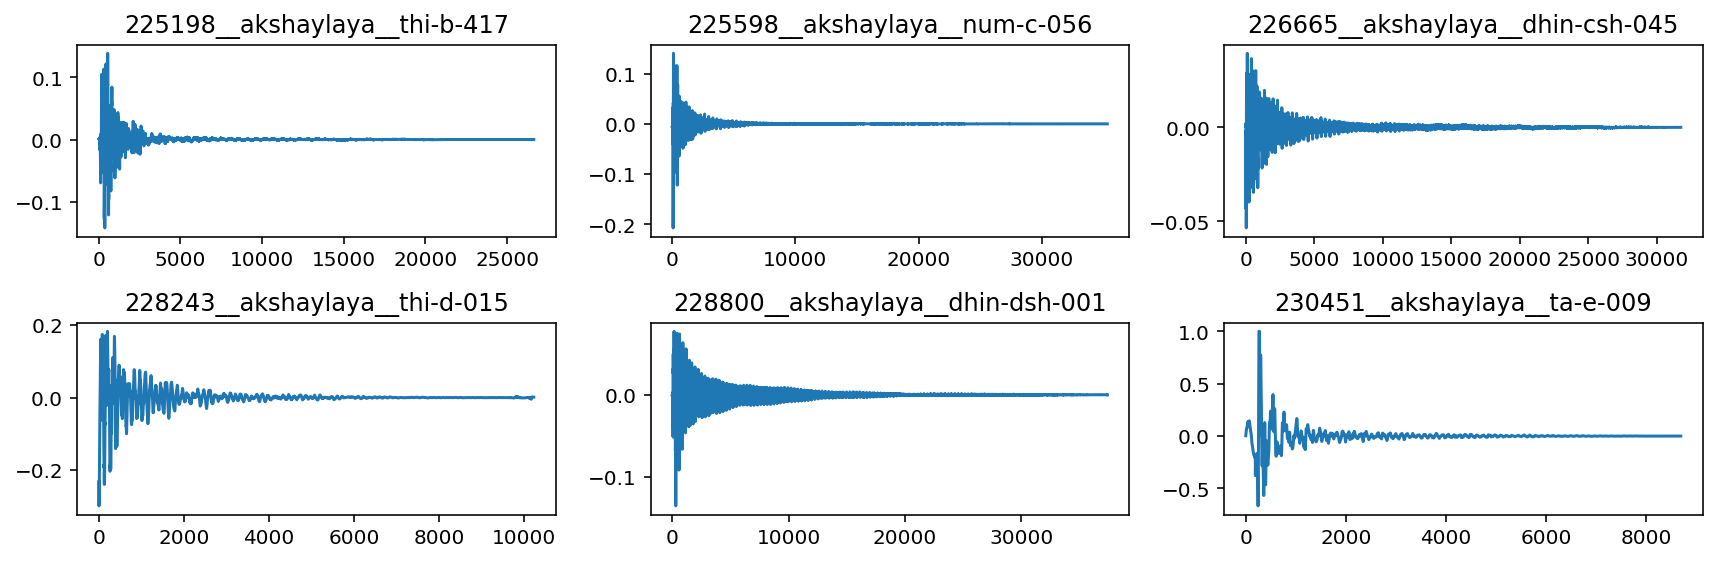

In [9]:
# Sample some files to plot (one for each tonic class)
df_sample = df_audiofiles.groupby('tonic_class')['filepath'] \
                         .apply(lambda group: group.sample(n=1, random_state=1))

# plot each sample
plt.figure(figsize=(2 * len(TONIC_CLASSES), 4))

for idx, sample_file in enumerate(df_sample):
    x = ess.MonoLoader(filename=sample_file, sampleRate=DATASET_FS)()

    plt.subplot(2, 3, (idx + 1))
    plt.plot(x)
    plt.tight_layout(pad=1.0)
    plt.title(Path(sample_file).stem)

**Observation:** All files contain a single stroke and therefore there is no need to segment data as it may occur with other datasets where several audio chunks that are supposed to be analyzed separately are grouped in a single audiofile. It is possible then to move to the feature extraction process.

# Feature extraction  
Let's compute a list of common features for each of the files and form a `DataFrame` including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. Let's first run it for a single file and check its output:

In [10]:
sample_file = df_audiofiles['filepath'][0]  # Pick first file in the list

features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                               lowlevelFrameSize=2048,
                                               lowlevelHopSize=1024,
                                               lowlevelStats=['mean', 'stdev'])(sample_file)

## Extract descriptor names
`essentia.MusicExtractor` extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

In [11]:
scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() 
                              if 'lowlevel' in descriptor and
                              isinstance(features[descriptor], float)]

df_scalar_lowlevel_descriptors = pd.DataFrame(scalar_lowlevel_descriptors, columns=['scalar_lowlevel_descriptors'])
display_all_rows(df_scalar_lowlevel_descriptors)

scalar_lowlevel_descriptors
0                        lowlevel.average_loudness
1                    lowlevel.barkbands_crest.mean
2                   lowlevel.barkbands_crest.stdev
3              lowlevel.barkbands_flatness_db.mean
4             lowlevel.barkbands_flatness_db.stdev
5                 lowlevel.barkbands_kurtosis.mean
6                lowlevel.barkbands_kurtosis.stdev
7                 lowlevel.barkbands_skewness.mean
8                lowlevel.barkbands_skewness.stdev
9                   lowlevel.barkbands_spread.mean
10                 lowlevel.barkbands_spread.stdev
11                        lowlevel.dissonance.mean
12                       lowlevel.dissonance.stdev
13                     lowlevel.dynamic_complexity
14                    lowlevel.erbbands_crest.mean
15                   lowlevel.erbbands_crest.stdev
16              lowlevel.erbbands_flatness_db.mean
17             lowlevel.erbbands_flatness_db.stdev
18                 lowlevel.erbbands_kurtosis.mean
19                lowlevel.erbbands_kurtosis.stdev
20                 lowlevel.erbbands_skewness.mean
21                lowlevel.erbbands_skewness.stdev
22                   lowlevel.erbbands_spread.mean
23                  lowlevel.erbbands_spread.stdev
24                               lowlevel.hfc.mean
25                              lowlevel.hfc.stdev
26             lowlevel.loudness_ebu128.integrated
27         lowlevel.loudness_ebu128.loudness_range
28         lowlevel.loudness_ebu128.momentary.mean
29        lowlevel.loudness_ebu128.momentary.stdev
30        lowlevel.loudness_ebu128.short_term.mean
31       lowlevel.loudness_ebu128.short_term.stdev
32                    lowlevel.melbands_crest.mean
33                   lowlevel.melbands_crest.stdev
34              lowlevel.melbands_flatness_db.mean
35             lowlevel.melbands_flatness_db.stdev
36                 lowlevel.melbands_kurtosis.mean
37                lowlevel.melbands_kurtosis.stdev
38                 lowlevel.melbands_skewness.mean
39                lowlevel.melbands_skewness.stdev
40                   lowlevel.melbands_spread.mean
41                  lowlevel.melbands_spread.stdev
42                    lowlevel.pitch_salience.mean
43                   lowlevel.pitch_salience.stdev
44                 lowlevel.silence_rate_20dB.mean
45                lowlevel.silence_rate_20dB.stdev
46                 lowlevel.silence_rate_30dB.mean
47                lowlevel.silence_rate_30dB.stdev
48                 lowlevel.silence_rate_60dB.mean
49                lowlevel.silence_rate_60dB.stdev
50                 lowlevel.spectral_centroid.mean
51                lowlevel.spectral_centroid.stdev
52               lowlevel.spectral_complexity.mean
53              lowlevel.spectral_complexity.stdev
54                 lowlevel.spectral_decrease.mean
55                lowlevel.spectral_decrease.stdev
56                   lowlevel.spectral_energy.mean
57                  lowlevel.spectral_energy.stdev
58          lowlevel.spectral_energyband_high.mean
59         lowlevel.spectral_energyband_high.stdev
60           lowlevel.spectral_energyband_low.mean
61          lowlevel.spectral_energyband_low.stdev
62   lowlevel.spectral_energyband_middle_high.mean
63  lowlevel.spectral_energyband_middle_high.stdev
64    lowlevel.spectral_energyband_middle_low.mean
65   lowlevel.spectral_energyband_middle_low.stdev
66                  lowlevel.spectral_entropy.mean
67                 lowlevel.spectral_entropy.stdev
68                     lowlevel.spectral_flux.mean
69                    lowlevel.spectral_flux.stdev
70                 lowlevel.spectral_kurtosis.mean
71                lowlevel.spectral_kurtosis.stdev
72                      lowlevel.spectral_rms.mean
73                     lowlevel.spectral_rms.stdev
74                  lowlevel.spectral_rolloff.mean
75                 lowlevel.spectral_rolloff.stdev
76                 lowlevel.spectral_skewness.mean
77                lowlevel.spectral_skewness.

## Extract features of all files  
Let's run `essentia.MusicExtractor` for all files, keeping a subset of features, writting to an output file `data.csv`.  

**Important:** In order to save time while executing this notebook, a file of precomputed features can be downloaded if `DOWNLOAD_PRECOMPUTED_DATA` is set to `True` in the **Dataset definitions** cell, otherwise features will be computed and stored on the fly.

In [12]:
def perform_feature_extraction(df_audiofiles=None, feature_set=[], output_file=None):
    """ Given a feature set, performs feature extraction in bulk.
        
        Perform feature extraction in all files in df_audiofiles DataFrame. Only
        features in feature_set will be stored in output_file. While files are
        being processed, a progress bar will be shown.
        Files raising and Exception during the feature extraction process will 
        be ignored.

    Args:
        df_audiofiles (DataFrame): DataFrame containing the list of files to be processed.
        feature_set (list): A list containing the feature set to be extracted.
        output_file (str): A path to the file where features will be written.
    """

    file_count = 0          # Counts the number of processed files.
    ignored_file_count = 0  # Counts the number of ignored files.

    with open(output_file, 'w') as writer:
        column_names = ','.join(scalar_lowlevel_descriptors + \
                                ['tonic_class'] + ['stroke_class']).replace('lowlevel.', '') + '\n'
        writer.write(column_names)

        iterator = tqdm(df_audiofiles.iterrows())
        iterator.set_description('Extracting audio file features\n')
    
        for idx, audio_file in iterator:
            file_count += 1

            if file_count % 20 == 0:  # Reports progress every 20 files
                iterator.set_postfix_str(f'File: {audio_file.filepath}')

            try:
                features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                               lowlevelFrameSize=2048,
                                                               lowlevelHopSize=1024,
                                                               lowlevelStats=['mean', 'stdev'])(audio_file.filepath)
        
                selected_features = [features[feature] for feature in feature_set]
                line2write = str(selected_features)[1:-1] + ',' + audio_file.tonic_class + ',' + audio_file.stroke_class + '\n'
                writer.write(line2write)
        
            except Exception:
                ignored_file_count += 1

    print(f'Total files: {file_count} / ignored files: {ignored_file_count}')

In [13]:
%%time
data_file = os.path.join(DATASET_ROOT, 'data.csv')

if not DOWNLOAD_PRECOMPUTED_DATA:
    perform_feature_extraction(df_audiofiles=df_audiofiles, feature_set=scalar_lowlevel_descriptors, output_file=data_file)
else:
    print('Precomputed data has been already downloaded (DOWNLOAD_PRECOMPUTED_DATA=True)')

Precomputed data has been already downloaded (DOWNLOAD_PRECOMPUTED_DATA=True)
CPU times: user 82 µs, sys: 20 µs, total: 102 µs
Wall time: 107 µs


# Feature preprocessing and analysis  
First the raw data file stored at `data_file` will be loaded into a `DataFrame` and inspected to see how it looks like.

In [14]:
df_raw = pd.read_csv(data_file)
display(df_raw.head())

average_loudness  barkbands_crest.mean  ...  tonic_class  stroke_class
0          0.990684             13.143802  ...           c#            ta
1          0.990684             16.743053  ...           c#          tham
2          0.990684             14.683802  ...           c#            ta
3          0.990684             22.059494  ...           c#         bheem
4          0.990684             12.312141  ...           c#           thi

[5 rows x 86 columns]

It is always good to check for `Nan` values that may imply incomplete rows that need to be handed accordingly depending on our task. If no `Nan` values are found, we are good to move to the next step.

In [15]:
nan_values = df_raw.isnull().sum().sum()
print(f'{nan_values} Nan values found')

0 Nan values found


## Data visualization  
It is always a good idea to inspect the data visually in order to observe what features are more useful for our tasks. Visualizing features can give an idea about how our data is distributed and by plotting feature pairs, we can observe the relationship between different descriptors. Let's first pick 2 features and plot an example using the `Seaborn` library.

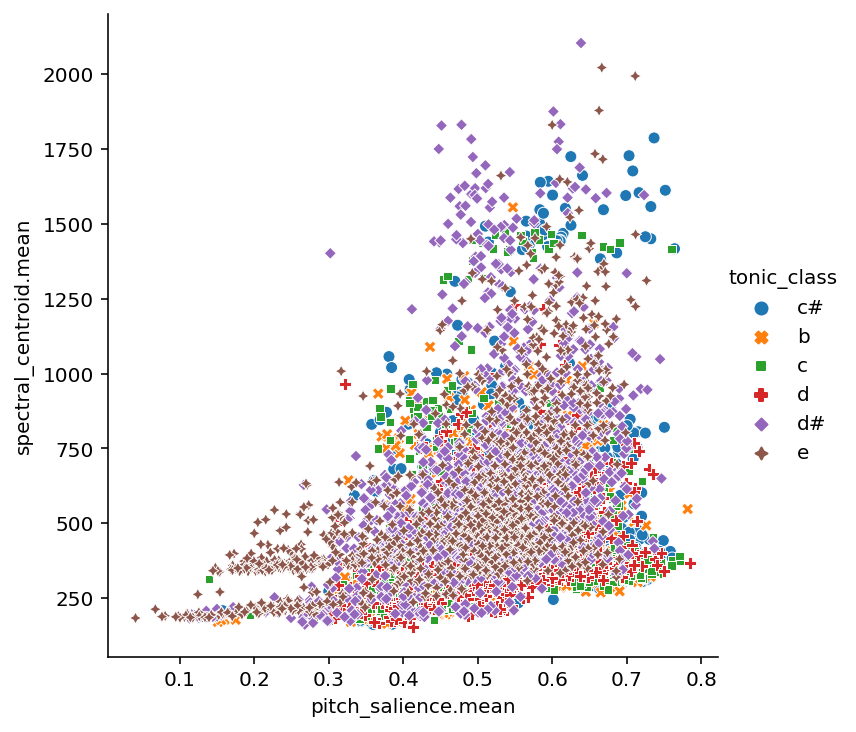

In [16]:
sns.relplot(x='pitch_salience.mean', y ='spectral_centroid.mean', hue='tonic_class', style='tonic_class', data=df_raw)
plt.show()

Now let's plot a selected number of features to have a better idea about how our dataset looks like and what can be useful for our first classification task with the goal of classifying by `tonic_class`. Some features that *a priori* seem informative for our task have been plotted, although any other feature can be plotted by adding it to the `features_to_plot` list in case we suspect it can be a useful one.

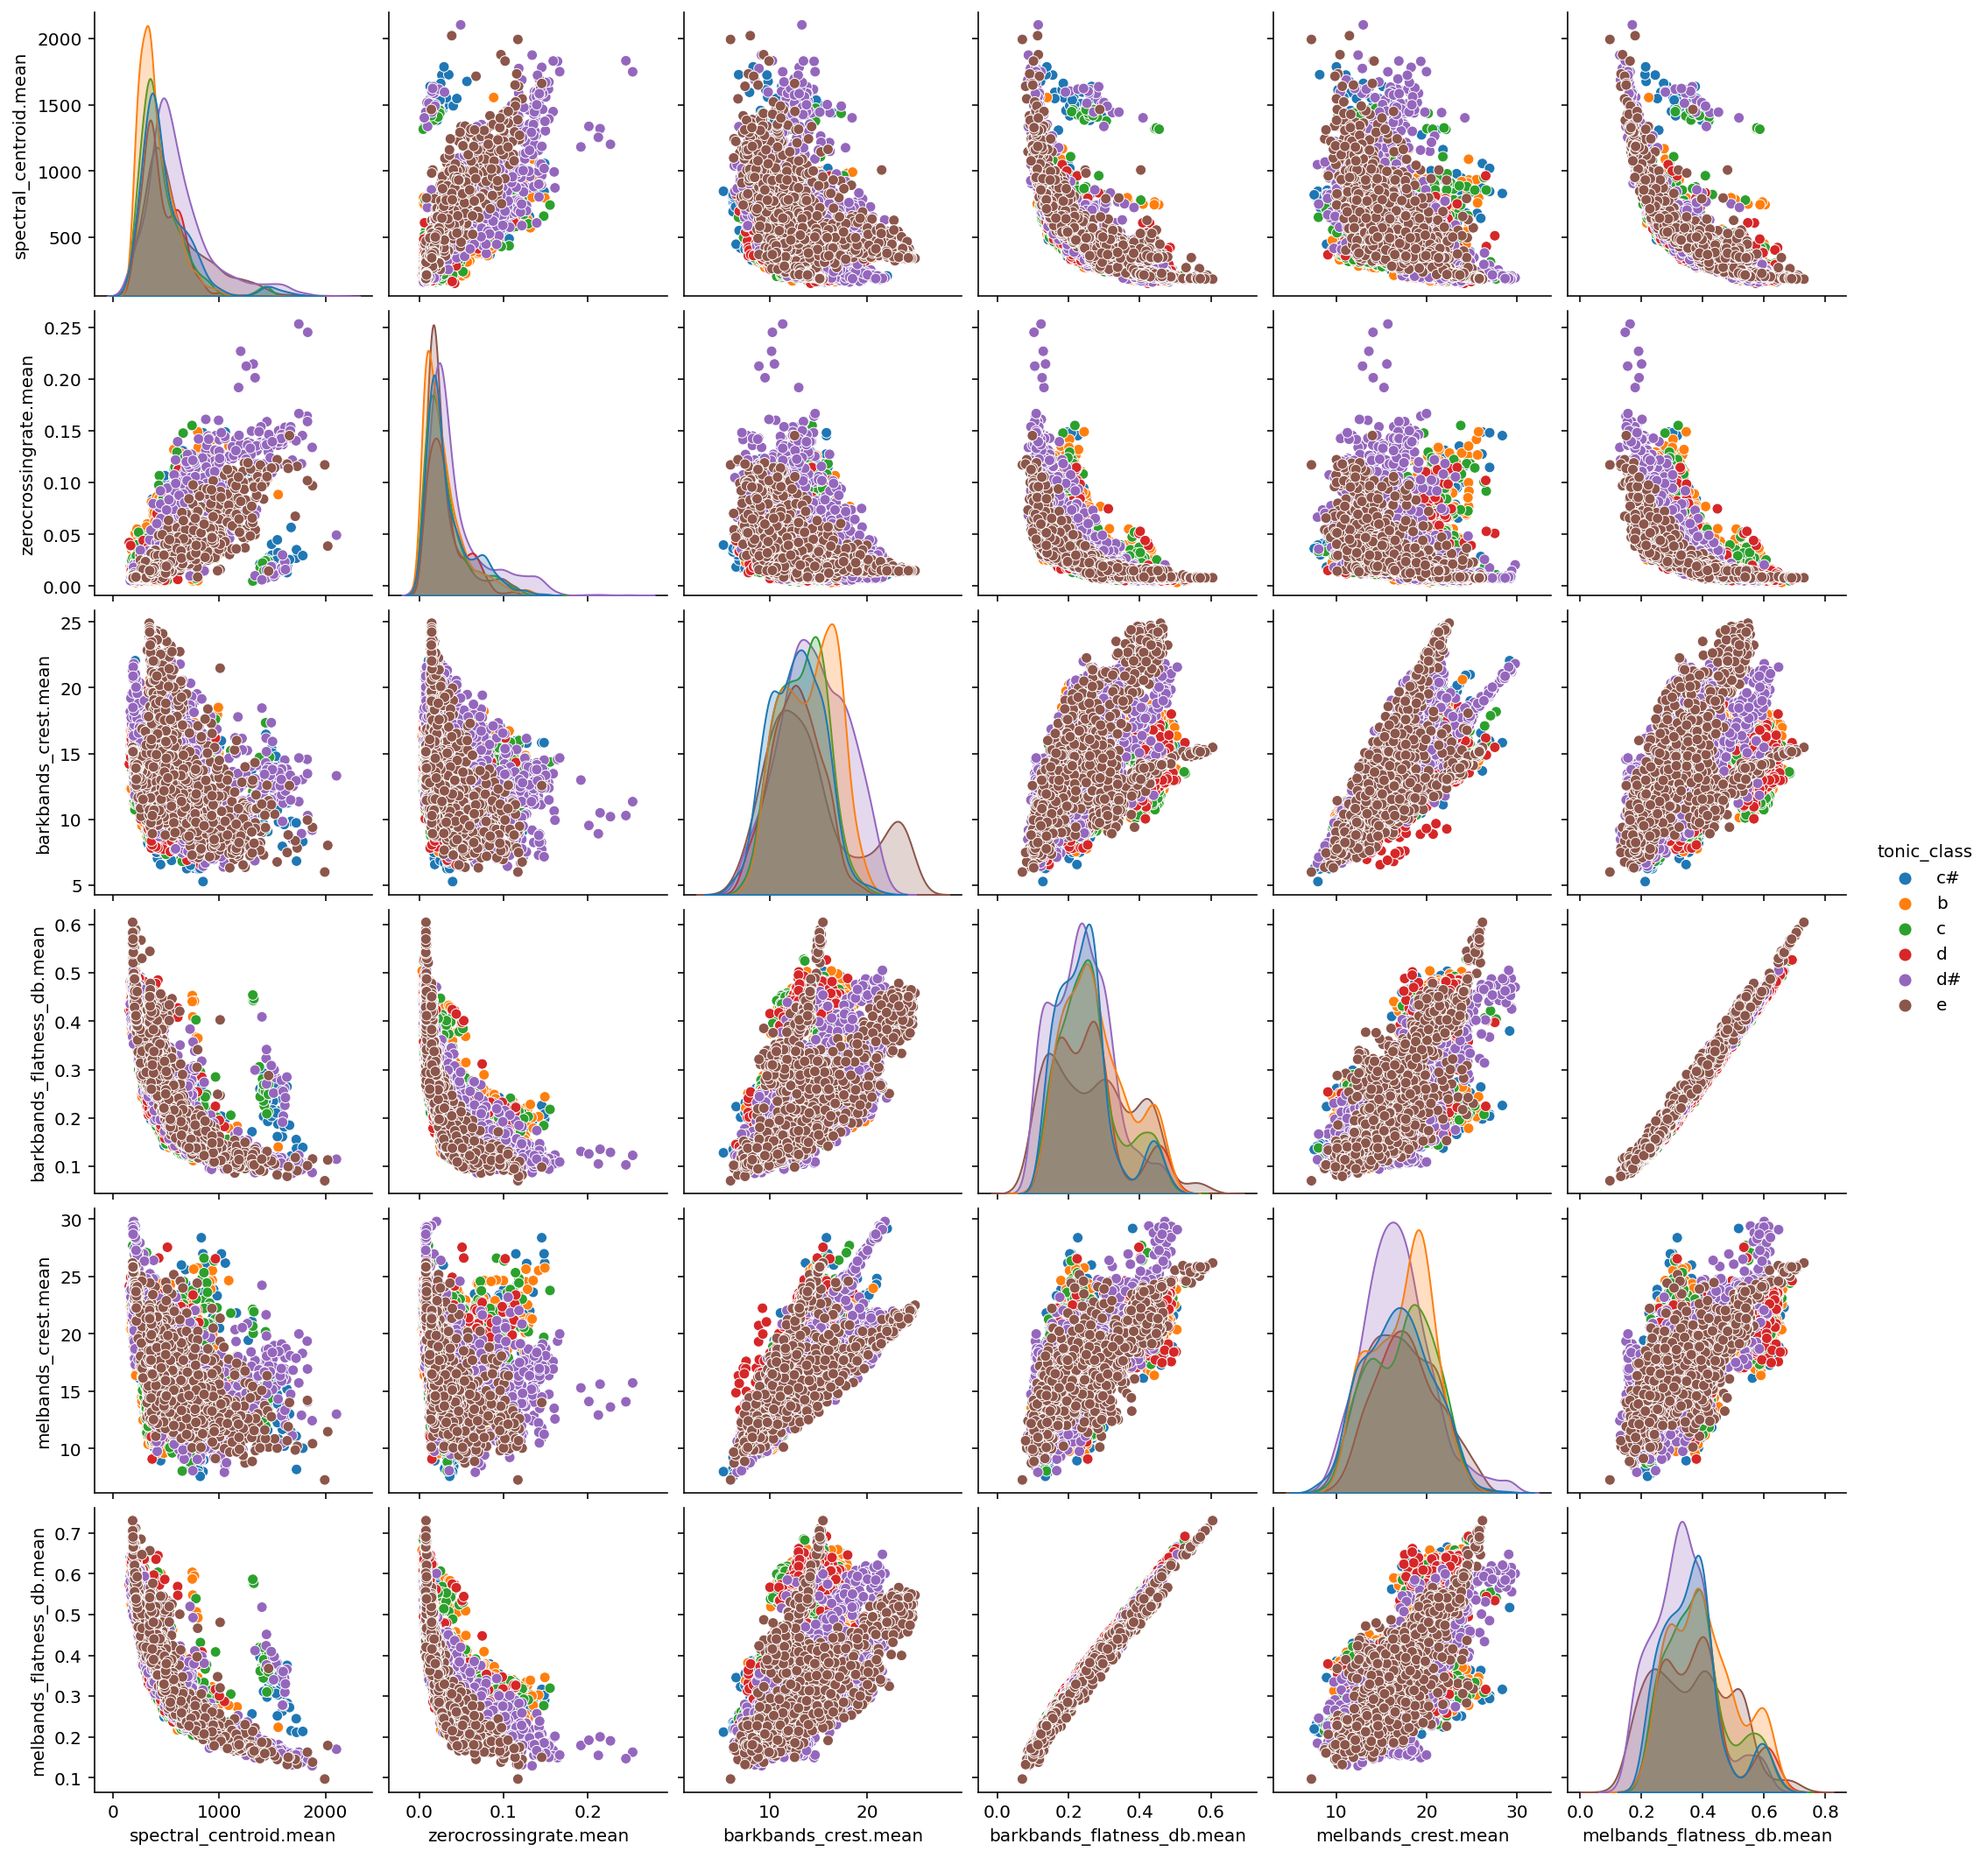

In [17]:
features_to_plot = ['spectral_centroid.mean',
                    'zerocrossingrate.mean',
                    'barkbands_crest.mean',
                    'barkbands_flatness_db.mean',
                    'melbands_crest.mean',
                    'melbands_flatness_db.mean',
                    'tonic_class']

sns.pairplot(df_raw[features_to_plot], hue='tonic_class')

## Simple data statistics  
Some simple statistic calculations along with the visualization of our data can greatly help to decide what features may be redundant to use or do not vary much in our dataset as well as which ones may be informative for our task.

**Observation:** `min`, `max` and `mean` values of the features vary a lot, we need to normalize them. Some of the features - such as `average_loudness` - may be irrelevant for the task.

In [18]:
df_raw.describe()

average_loudness  ...  zerocrossingrate.stdev
count       6977.000000  ...             6977.000000
mean           0.990642  ...                0.018373
std            0.003487  ...                0.021053
min            0.699401  ...                0.000000
25%            0.990684  ...                0.005080
50%            0.990684  ...                0.009203
75%            0.990684  ...                0.023196
max            0.990684  ...                0.175252

[8 rows x 84 columns]

## Preprocessing the features  
Now that we have a little more information about how the raw data looks like, it's time to perform some preprocessing steps in order to make it more suitable for the classification tasks. First, the data will be **normalized** using the `MinMaxScaler` class from `sklearn`. Multiple version or different sequences of steps in the raw data may be needed for other tasks, thus, `df_raw` (our raw data) will be first copied and then the normalization process will be applied to the copy. Moreover, this copy of the data will be named `df_tonic_norm` to clearly identify that it is related with the **tonic classification** task and that is normalized.

In [19]:
df_tonic_norm = df_raw.copy()
min_max_scaler = MinMaxScaler()
df_tonic_norm.iloc[:, :-2] = min_max_scaler.fit_transform(df_tonic_norm.iloc[:, :-2])  # Last 2 columns are categorical data

df_tonic_norm.describe()  # See stats again to see how they changed after transform

average_loudness  ...  zerocrossingrate.stdev
count       6977.000000  ...             6977.000000
mean           0.999857  ...                0.104837
std            0.011972  ...                0.120129
min            0.000000  ...                0.000000
25%            1.000000  ...                0.028987
50%            1.000000  ...                0.052513
75%            1.000000  ...                0.132357
max            1.000000  ...                1.000000

[8 rows x 84 columns]

Now that data has been normalized, we can move on and see if there is any potential data imbalance problem and in such case, use some technique to overcome this issue.

## Data distribution plot helper function  
A simple function will be defined to be reused in later situations where a visualization of how our data is distributed can be useful.

In [20]:
def plot_class_distribution_barplot(df_class):
    """" Generates a bar plot including each class on df_class. 
    
    Args:
        df_class (Series): Series of the target class.
    """
    class_distribution = df_class.value_counts()

    value_counts_plot = class_distribution.plot(kind='bar')


    for bar in value_counts_plot.patches:
        value_counts_plot.annotate(bar.get_height(),  
                                   (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='center', 
                                   size=9, xytext=(0, 4), 
                                   textcoords='offset points')
    
    value_counts_plot.set_title(f'Amount of instances per {df_class.name}')
    value_counts_plot.set_xlabel(f'{df_class.name}')
    value_counts_plot.set_ylabel('instances')
    plt.show()

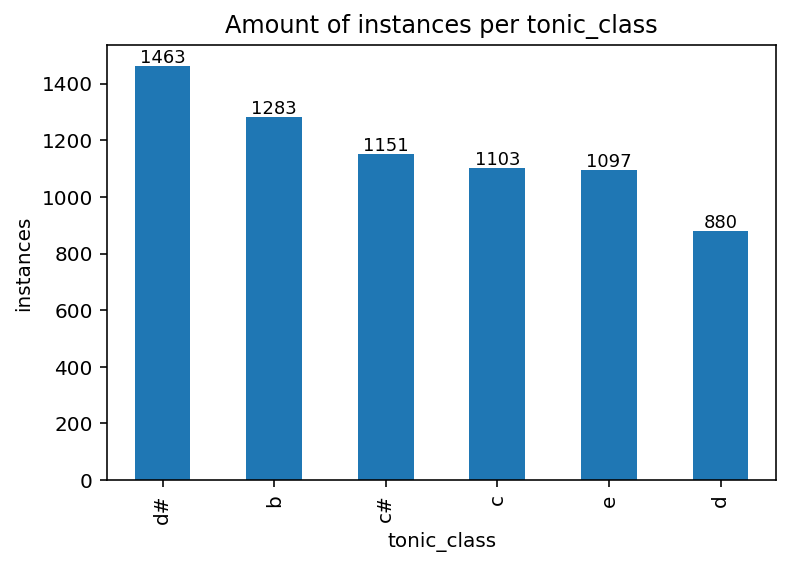

In [21]:
plot_class_distribution_barplot(df_tonic_norm.tonic_class)

**Observation**: The data is imbalanced. Several techniques can be applied such as oversampling or undersampling to have a similar amount of instances per class. We don't want to loose data of the most populated classes and therefore a combination of oversampling and undersampling called [SMOTETomek](https://imbalanced-learn.org/stable/generated/imblearn.combine.SMOTETomek.html) using SMOTE and cleaning using Tomek links will be utilized. 

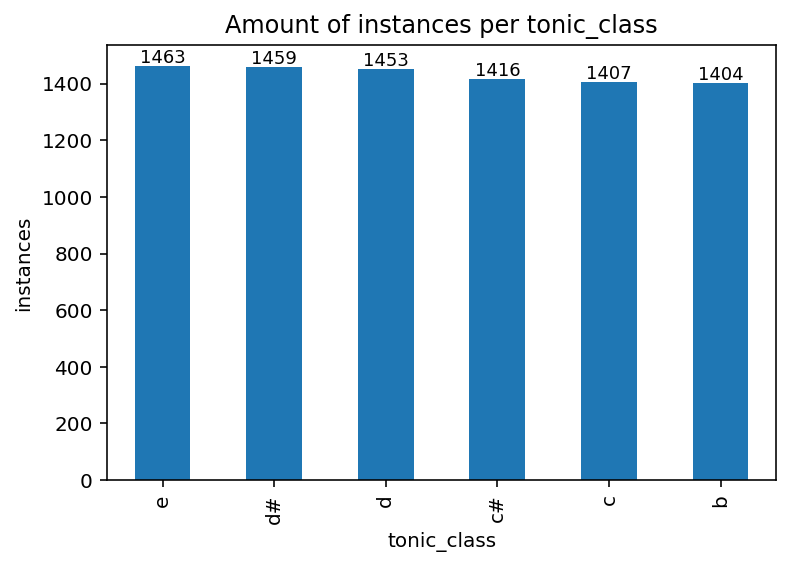

In [22]:
smk = SMOTETomek(random_state=1)

df_X_tonic_norm = df_tonic_norm.drop(['tonic_class', 'stroke_class'], axis=1)
df_y_tonic_norm = df_tonic_norm[['tonic_class']]
df_y_tonic_norm.tonic_class = pd.Categorical(df_y_tonic_norm.tonic_class)

# Get SMOTETomek data as np.array
X_tonic_norm_bal, y_tonic_norm_bal = smk.fit_sample(df_X_tonic_norm, df_y_tonic_norm)

# Reconstruct DataFrame for plotting
df_tonic_norm_bal = pd.concat([pd.DataFrame(X_tonic_norm_bal),
                                   pd.DataFrame(y_tonic_norm_bal)],
                                   axis=1)

df_tonic_norm_bal.columns = df_tonic_norm.drop(['stroke_class'], axis=1).columns

plot_class_distribution_barplot(df_tonic_norm_bal.tonic_class)

## Categorical data
`tonic_class` column should be turned into categorical data, this way it can be fed to a classifier.

In [23]:
df_tonic_norm_bal.tonic_class = pd.Categorical(df_tonic_norm_bal.tonic_class)
df_tonic_norm_bal.tonic_class.dtype  # The column have been turned into a categorical dtype

CategoricalDtype(categories=['b', 'c', 'c#', 'd', 'd#', 'e'], ordered=False)

# Testing a tonic class classifier  
Now that the data is ready to train a classifier, a `svm.SVC` from `sklearn` will be trained using a test/train split of 0.33 as an example.

In [24]:
X_tonic_norm_bal = df_tonic_norm_bal.drop(['tonic_class'], axis=1).values
y_tonic_norm_bal = np.array(df_tonic_norm_bal.tonic_class.cat.codes)

(X_tonic_norm_bal_train, X_tonic_norm_bal_test, 
y_tonic_norm_bal_train, y_tonic_norm_bal_test) = train_test_split(X_tonic_norm_bal, 
                                                                  y_tonic_norm_bal, 
                                                                  test_size=0.33,
                                                                  random_state=1)

clf_tonic_example = SVC(gamma=1 / (X_tonic_norm_bal_train.shape[-1] * X_tonic_norm_bal_train.var()))
clf_tonic_example.fit(X_tonic_norm_bal_train, y_tonic_norm_bal_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.15775556477860067,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

# Testing the model  
Now that the model is trained, a basic testing will be performed and the accuracy will be calculated.

In [25]:
y_tonic_norm_bal_predict = clf_tonic_example.predict(X_tonic_norm_bal_test)
tonic_example_clf_accuracy = accuracy_score(y_tonic_norm_bal_test,
                                            y_tonic_norm_bal_predict)

print(f'Accuracy: {tonic_example_clf_accuracy:.2f}')

Accuracy: 0.72


## Test model confusion matrix  
Finally, the confusion matrix is shown.

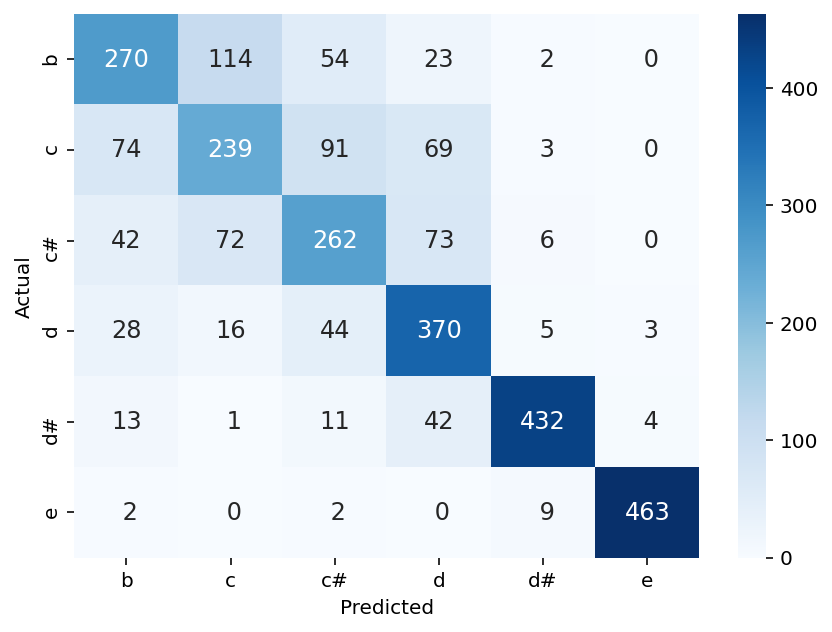

In [26]:
tonic_classes = TONIC_CLASSES.values()
tonic_conf_matrix = pd.DataFrame(confusion_matrix(y_tonic_norm_bal_test,
                                                  y_tonic_norm_bal_predict),
                                 columns=tonic_classes,
                                 index=tonic_classes)
tonic_conf_matrix.index.name = 'Actual'
tonic_conf_matrix.columns.name = 'Predicted'

plt.figure(figsize=(7, 5))
sns.heatmap(tonic_conf_matrix, cmap='Blues', annot_kws={'size': 12}, annot=True, fmt='2g')
plt.show()

# Standalone use of test model  
Now that the model is trained, we have the tools to perform automatic tonic classification of isolated files. Below is the code to run classification on audio files. This cell does not aim testing (because it also includes the training samples) but just a demonstration of the predictions of our model.    

First, a function to pass a classifier and enable predictions will be created and then it will be used to test our model.

In [27]:
def predict_tonic_class(audio_file,
                        selected_features_names=scalar_lowlevel_descriptors,
                        scaler=None,
                        classifier=None,
                        classes=TONIC_CLASSES):
    """ Predicts the tonic_class given an audiofile and a classifier.
    
    Args:
        audio_file (str): Path of the audio file to be classified.
        selected_feature_names (list): List of features to be used for classification.
        scaler: A scaler class from sklearn to be applied to the data.
        classifier: A classifier from sklearn.
        classes (list): List containing the possible tonic classes.

    Returns:
        The predicted class.
    """
    # Extract features
    features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                 lowlevelFrameSize=2048,
                                                 lowlevelHopSize=1024,
                                                 lowlevelStats=['mean', 'stdev'])(audio_file)
    selected_features = [features[descriptor] for descriptor in selected_features_names]

    # If a scaler is given, scaling is performed
    if scaler != None: features = scaler.transform(np.array(selected_features).reshape(1, -1))

    y_predicted = classifier.predict(features)

    return list(classes.values())[y_predicted[0]]

Using the function to classify some samples from the original files.

In [28]:
# Get some random files to test the classification
samples_to_predict = df_audiofiles.groupby('tonic_class')['filepath'] \
                        .apply(lambda group: group.sample(n=3, random_state=1))

# Make some predictions
for sample in samples_to_predict:
    predicted_tonic_class = predict_tonic_class(sample, classifier=clf_tonic_example, scaler=min_max_scaler)
    print(f'{Path(sample).stem} predicted as {predicted_tonic_class}')

225198__akshaylaya__thi-b-417 predicted as b
224409__akshaylaya__ta-b-061 predicted as b
224827__akshaylaya__thi-b-046 predicted as b
225598__akshaylaya__num-c-056 predicted as c
226091__akshaylaya__thi-c-020 predicted as c
226039__akshaylaya__tham-c-048 predicted as c
226665__akshaylaya__dhin-csh-045 predicted as c#
227382__akshaylaya__thi-csh-139 predicted as c#
227279__akshaylaya__thi-csh-036 predicted as c#
228243__akshaylaya__thi-d-015 predicted as d
228404__akshaylaya__thi-d-166 predicted as d
228555__akshaylaya__thom-d-032 predicted as b
228800__akshaylaya__dhin-dsh-001 predicted as d#
228715__akshaylaya__dheem-dsh-027 predicted as d#
229426__akshaylaya__tha-dsh-152 predicted as b
230451__akshaylaya__ta-e-009 predicted as e
230167__akshaylaya__cha-e-007 predicted as e
230149__akshaylaya__bheem-e-014 predicted as e


There is still a lot of other strategies and classifier to test and see what performs best. In the following section, a collection of classifiers will be tested to get the best one among a few available ones.

# Comparing tonic class classifiers
A few different classifiers are going to be trained this time using 10-fold  cross-validation to be tester later on.  

<font color="red">**Important:** Please notice that some classifiers of `tonic_clfs` have been commented out to save time running the cell.  
**Spoiler alert!:** `KNeighborsClassifier` and `DecisionTreeClassifier` were the ones that gave the best results).</font>

In [29]:
%%time

tonic_clfs = {
    'KNN': KNeighborsClassifier(3),
    #'Linear SVM': SVC(kernel='linear', C=0.025),
    #'RBF SVM': SVC(gamma=1 / (X_tonic_norm_bal_train.shape[-1] * X_tonic_norm_bal_train.var())),
    #'Gaussian Process': GaussianProcessClassifier(1.0 * RBF(1.0)),  # Gaussian Process has been skipped because it takes a very long time to compute
    #'Neural Net': MLPClassifier(alpha=1, max_iter=1000),
    #'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=1),
}

# DataFrame to store scores
tonic_clf_scores = pd.DataFrame(columns=['name', 'score.mean', 'score.std'])

for clf in tonic_clfs:
    score = cross_val_score(tonic_clfs[clf], X_tonic_norm_bal, y_tonic_norm_bal, cv=10)
    tonic_clf_scores = tonic_clf_scores.append({'name': clf,
                                              'score.mean': score.mean(),
                                              'score.std': score.std()},
                                               ignore_index=True)

display(tonic_clf_scores.sort_values('score.mean', ascending=False))

name  score.mean  score.std
0            KNN    0.853060   0.041906
1  Decision Tree    0.767386   0.053067

CPU times: user 18.6 s, sys: 15.8 ms, total: 18.6 s
Wall time: 18.6 s


# Basic feature selection  
The best scoring model among the ones that are computed is the `KNeighborsClassifier`. Before moving to the next task, a basic feature selection process will be incorporated to see if it improves the score or efficiency of this classifier. A very simple feature selection technique will be used which is `SelectPercentile`. This function will select only 50% of the features based on `f_classif` that uses ANOVA F-value as shown in [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html).

In [30]:
X_tonic_norm_bal_selected = SelectPercentile(f_classif, percentile=40) \
                                            .fit_transform(X_tonic_norm_bal, y_tonic_norm_bal)

score_selected = cross_val_score(tonic_clfs['KNN'], X_tonic_norm_bal_selected, y_tonic_norm_bal, cv=10)
df_scores_selected = pd.DataFrame([{'name': 'KNN', 'score.mean': score_selected.mean(), 'score.std': score_selected.std()}])
display(df_scores_selected)

name  score.mean  score.std
0  KNN    0.857594   0.036857

**Observation**: By using `SelectPercentile` the score did not changed significantly, however, the training process is now faster since similar results can be achieved using only 40% of the features.

# Confusion Matrix  
Finally the confusion matrix of the `KNeighborsClassifier` is plotted below.

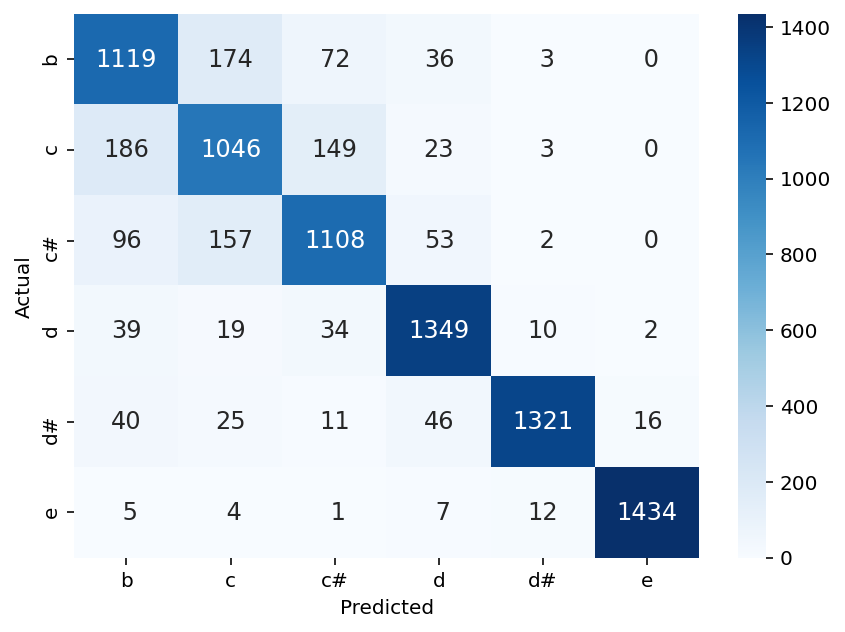

In [31]:
y_tonic_norm_bal_predict = cross_val_predict(tonic_clfs['KNN'], X_tonic_norm_bal_selected, y_tonic_norm_bal, cv=10)

tonic_classes = TONIC_CLASSES.values()
tonic_conf_matrix = pd.DataFrame(confusion_matrix(y_tonic_norm_bal,
                                                  y_tonic_norm_bal_predict),
                                 columns=tonic_classes,
                                 index=tonic_classes)
tonic_conf_matrix.index.name = 'Actual'
tonic_conf_matrix.columns.name = 'Predicted'

plt.figure(figsize=(7, 5))
sns.heatmap(tonic_conf_matrix, cmap='Blues', annot_kws={'size': 12}, annot=True, fmt='2g')
plt.show()

# Second task: Stroke classification  
Now to extend this notebook. A `stroke_class` classifier will be implemented. This time, different ways of facing class imbalance and dimensionality reduction will be implemented in order to explore some other available techniques. 

**Observation:** Some of the following steps may look redundant, however they will be coded for the sake of completeness of this notebook.

## Investigating raw data  
One sample is taken for each stroke class in order to get an idea about how our waveform data looks like.

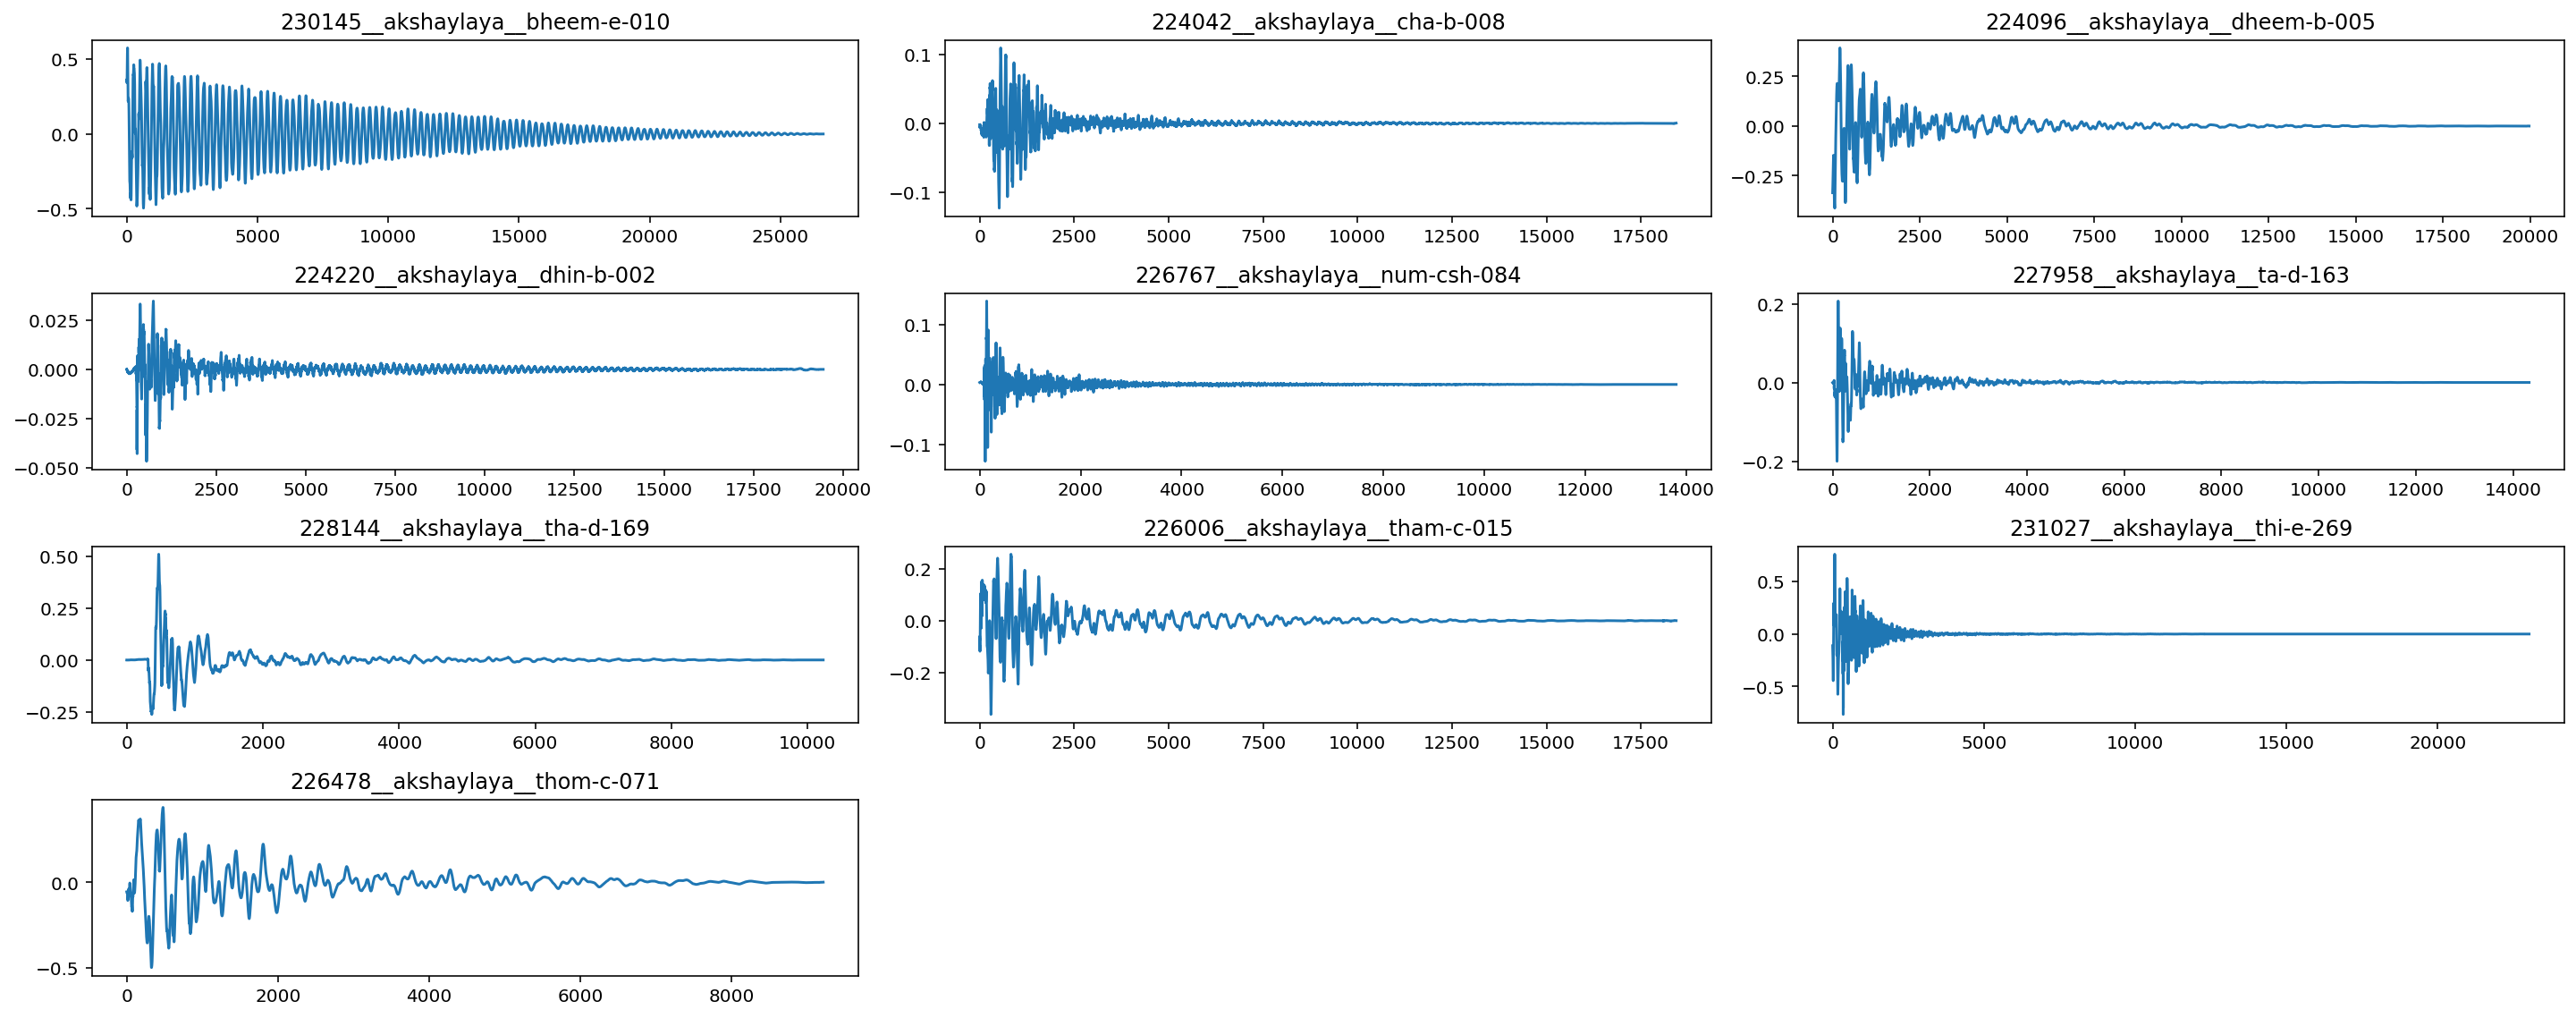

In [32]:
# Sample some files to plot (one for each tonic class)
df_sample = df_audiofiles.groupby('stroke_class')['filepath'] \
                         .apply(lambda group: group.sample(n=1, random_state=1))

# plot each sample
plt.figure(figsize=(2 * len(STROKE_CLASSES), 8))

for idx, sample_file in enumerate(df_sample):
    x = ess.MonoLoader(filename=sample_file, sampleRate=DATASET_FS)()

    plt.subplot(4, 3, (idx + 1))
    plt.plot(x)
    plt.tight_layout(pad=1.0)
    plt.title(Path(sample_file).stem)

## Simple data statistics 
Some useful basic statistical descriptors to remember how our normalized data looks like.

In [33]:
df_stroke_norm = df_raw.copy()  # Another data copy from raw data
df_stroke_norm.iloc[:, :-2] = min_max_scaler.fit_transform(df_stroke_norm.iloc[:, :-2])  # Last 2 columns are categorical data
df_stroke_norm.describe()  # See stats again to see how it looks like after transform

average_loudness  ...  zerocrossingrate.stdev
count       6977.000000  ...             6977.000000
mean           0.999857  ...                0.104837
std            0.011972  ...                0.120129
min            0.000000  ...                0.000000
25%            1.000000  ...                0.028987
50%            1.000000  ...                0.052513
75%            1.000000  ...                0.132357
max            1.000000  ...                1.000000

[8 rows x 84 columns]

## Data distribution

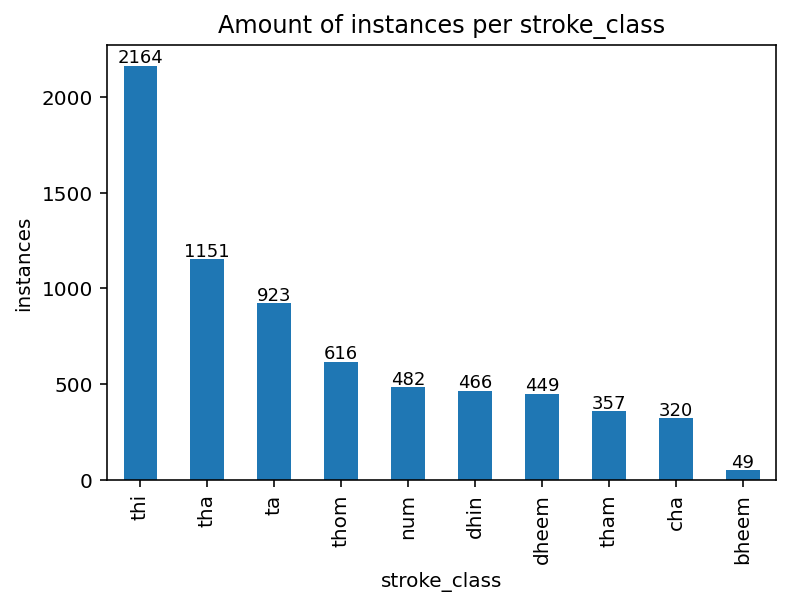

In [34]:
plot_class_distribution_barplot(df_tonic_norm.stroke_class)

**Observation:** This time the data is considerably more imbalanced than in the previous task. Downsampling probably would not be a good strategy since many instances of the training data would be lost and the remaining data would probably not be enough. `SMOTETomek` will be applied once again.

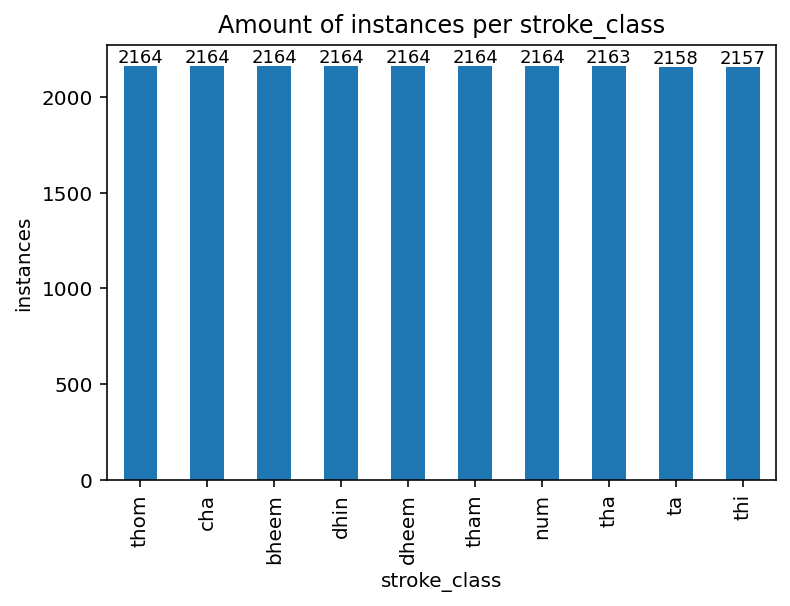

In [35]:
smk = SMOTETomek(random_state=1)

df_X_stroke_norm = df_stroke_norm.drop(['tonic_class', 'stroke_class'], axis=1)
df_y_stroke_norm = df_stroke_norm[['stroke_class']]
df_y_stroke_norm.tonic_class = pd.Categorical(df_y_stroke_norm.stroke_class)

# Get oversampled data as np.array
X_stroke_norm_bal, y_stroke_norm_bal = smk.fit_sample(df_X_stroke_norm, df_y_stroke_norm)

# Reconstruct DataFrame for plotting
df_stroke_norm_bal = pd.concat([pd.DataFrame(X_stroke_norm_bal),
                                pd.DataFrame(y_stroke_norm_bal)],
                                axis=1)

df_stroke_norm_bal.columns = df_stroke_norm.drop(['tonic_class'], axis=1).columns

plot_class_distribution_barplot(df_stroke_norm_bal.stroke_class)

## Preparing the data

This time `stroke_class` column should be turned into categorical data, this way it can be fed to a classifier. Additionally `df_stroke_norm_bal` will be split into `X_stroke_norm_bal` and `y_stroke_norm_bal` to be fed into the classifiers.

In [36]:
df_stroke_norm_bal.stroke_class = pd.Categorical(df_stroke_norm_bal.stroke_class, ordered=None)
df_stroke_norm_bal.stroke_class.dtype  # The column have been turned into a categorical dtype

X_stroke_norm_bal = df_stroke_norm_bal.drop(['stroke_class'], axis=1).values
y_stroke_norm_bal = np.array(df_stroke_norm_bal.stroke_class.cat.codes)

print(df_stroke_norm_bal.stroke_class.cat.categories)

Index(['bheem', 'cha', 'dheem', 'dhin', 'num', 'ta', 'tha', 'tham', 'thi',
       'thom'],
      dtype='object')


## Choosing a baseline classifier to improve  
Similarly to the tonic classification task, here a bunch of classifiers will be tested in order to pick the best one and move on implementing some feature selection and/or dimensionality reduction strategies to see how these improve the classifier (or maybe make it worse!). Again, 10-fold cross-validation will be used to perform these tests. `RandomForestClassifier` has been added to the list of classifiers this time.

<font color="red">**Important:** Please notice that some classifiers of `stroke_clfs` have been commented out to save time running the cell.  
**Spoiler alert!:** `KNeighborsClassifier` and `RandomForestClassifier` were the ones that gave the best results).</font>

In [37]:
%%time

stroke_clfs = {
    'KNN': KNeighborsClassifier(3),
    #'Linear SVM': SVC(kernel='linear', C=0.025),
    #'RBF SVM': SVC(gamma=1 / (X_stroke_norm_bal.shape[-1] * X_stroke_norm_bal.var())),
    #'Neural Net': MLPClassifier(alpha=1, max_iter=1000),
    #'Naive Bayes': GaussianNB(),
    #'Decision Tree': DecisionTreeClassifier(random_state=1),
    'Random Forest': RandomForestClassifier(random_state=1)
}

# DataFrame to store scores
stroke_clf_scores = pd.DataFrame(columns=['name', 'score.mean', 'score.std'])

for clf in stroke_clfs:
    score = cross_val_score(stroke_clfs[clf], X_stroke_norm_bal, y_stroke_norm_bal, cv=10)
    stroke_clf_scores = stroke_clf_scores.append({'name': clf,
                                              'score.mean': score.mean(),
                                              'score.std': score.std()},
                                               ignore_index=True)

display(stroke_clf_scores.sort_values('score.mean', ascending=False))

name  score.mean  score.std
1  Random Forest    0.986914   0.004151
0            KNN    0.968788   0.006534

CPU times: user 3min 24s, sys: 93.1 ms, total: 3min 24s
Wall time: 3min 24s


## Principal Component Analysis (PCA)  
In the previous classification task, `SelectPercentile` was used to reduce the number of features fed into the classifier. For this task, Principal Component Analysis will be explored as a tradeoff of accuracy and dimensionality reduction. A scree plot is shown in order to visualize how much of the information is explained by each principal component.

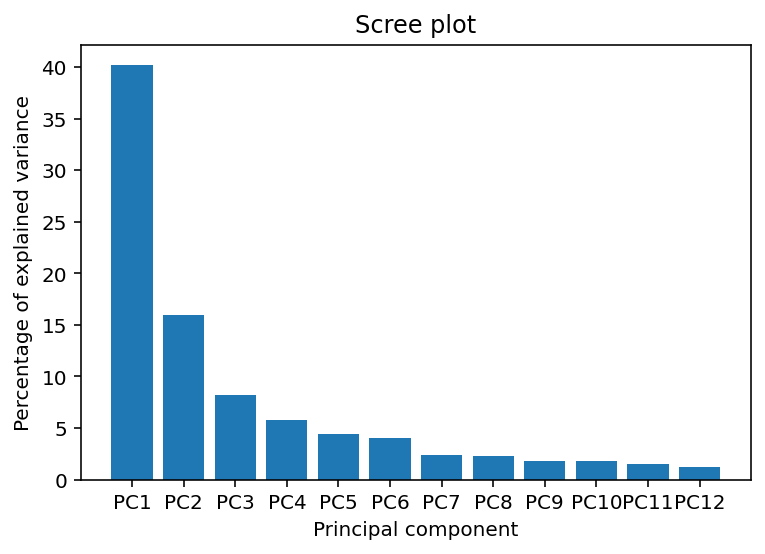

name  score.mean  score.std
0  Random Forest    0.968557    0.00715

In [38]:
stroke_PCA = PCA(n_components=12)
X_PCA = stroke_PCA.fit_transform(X_stroke_norm_bal)

variance_percentage = np.round(stroke_PCA.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(variance_percentage) + 1)]

plt.bar(x=range(1, len(variance_percentage) + 1), height=variance_percentage, tick_label=labels)
plt.title('Scree plot')
plt.xlabel('Principal component')
plt.ylabel('Percentage of explained variance')
plt.show()

scores_PCA = cross_val_score(stroke_clfs['Random Forest'], X_PCA, y_stroke_norm_bal, cv=10)
df_scores_PCA = pd.DataFrame([{'name': 'Random Forest', 'score.mean': scores_PCA.mean(), 'score.std': scores_PCA.std()}])
display(df_scores_PCA)

**Observation:** The model lost some percentage of accuracy after using only 12 PCAs, however, the dimensionality of the data has been also greatly reduced. Such reduction may be reasonable to embrace when reducing the training time of the model or maybe reducing data storage is a concern. Additionaly, it can be observed that even when `PC1` explains most of the variance, some of the other components also explain a significant part of it.

## Confusion matrix of the selected classifier  
Finally the confusion matrix of the `RandomForestClassifier` is plotted below.

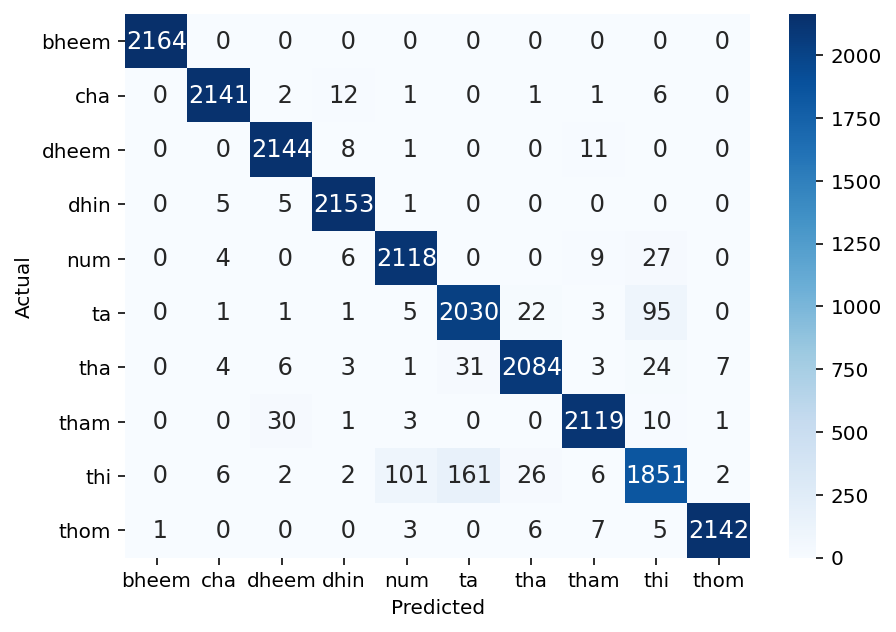

In [39]:
y_stroke_norm_bal_predict = cross_val_predict(stroke_clfs['Random Forest'], X_PCA, y_stroke_norm_bal, cv=10)

stroke_classes = STROKE_CLASSES.values()
stroke_conf_matrix = pd.DataFrame(confusion_matrix(y_stroke_norm_bal,
                                                   y_stroke_norm_bal_predict),
                                 columns=stroke_classes,
                                 index=stroke_classes)
stroke_conf_matrix.index.name = 'Actual'
stroke_conf_matrix.columns.name = 'Predicted'

plt.figure(figsize=(7, 5))
sns.heatmap(stroke_conf_matrix, cmap='Blues', annot_kws={'size': 12}, annot=True, fmt='2g')
plt.show()

## Conclusions and future work  
The current exemplary MIR workflow assignment has allowed us to understand the steps involved in the cycle of a MIR researcher's task that involves not only good programming skills, but also to obviously understand the task, visualize the dataset, organise the next steps and plan and execute accordingly given a target goal and a given amount of time before the deadline.

There is no unique way of approaching a particular MIR problem and therefore, many different combinations of techniques for data visualization, model selection, feature selection and dimensionality reduction were tested, however, this is not by any means an exhaustive notebook about those.

Additionally, only model comparison is performed throughout the notebook, but many other benchmarking could be performed among different feature elimination or dimensionality reduction techniques. Also, performing different data balancing techniques and comparing models whose only variation are the hyperparameters can generate insightful results that are interesting to evaluate to gain a deeper understanding about all existing algorithms and practices.